## Dipu Ghosh
## 221-35-873
## Section: 37_B1

## Importing necessary Library

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

## Load & Split the Dataset

In [2]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],  # 70% train, 15% val, 15% test
    with_info=True,
    as_supervised=True
)


print(f"Total samples: {ds_info.splits['train'].num_examples}")
print(f"Training samples: {int(ds_info.splits['train'].num_examples * 0.70)}")
print(f"Validation samples: {int(ds_info.splits['train'].num_examples * 0.15)}")
print(f"Test samples: {int(ds_info.splits['train'].num_examples * 0.15)}")
print(f"Number of classes: {ds_info.features['label'].num_classes}")
print(f"Class names: {ds_info.features['label'].names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.UMFR7N_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Total samples: 23262
Training samples: 16283
Validation samples: 3489
Test samples: 3489
Number of classes: 2
Class names: ['cat', 'dog']


In [3]:
IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

## Data Preprocessing

In [4]:
def preprocess_image(image, label):

    # Resize image to target size
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

## Data Augmentation

In [5]:
def augment_image(image, label):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Ensure values stay in [0,1] range
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

## PREPARE TRAINING, VALIDATION AND TEST DATASETS

In [6]:
# Prepare training dataset with augmentation
ds_train_processed = (ds_train
                     .map(preprocess_image, num_parallel_calls=AUTOTUNE)
                     .map(augment_image, num_parallel_calls=AUTOTUNE)
                     .cache()
                     .shuffle(1000)
                     .batch(BATCH_SIZE)
                     .prefetch(AUTOTUNE))

In [7]:
# Prepare validation dataset (no augmentation)
ds_val_processed = (ds_val
                   .map(preprocess_image, num_parallel_calls=AUTOTUNE)
                   .cache()
                   .batch(BATCH_SIZE)
                   .prefetch(AUTOTUNE))

In [8]:
# Prepare test dataset (no augmentation)
ds_test_processed = (ds_test
                    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
                    .cache()
                    .batch(BATCH_SIZE)
                    .prefetch(AUTOTUNE))

## Data Visulatization

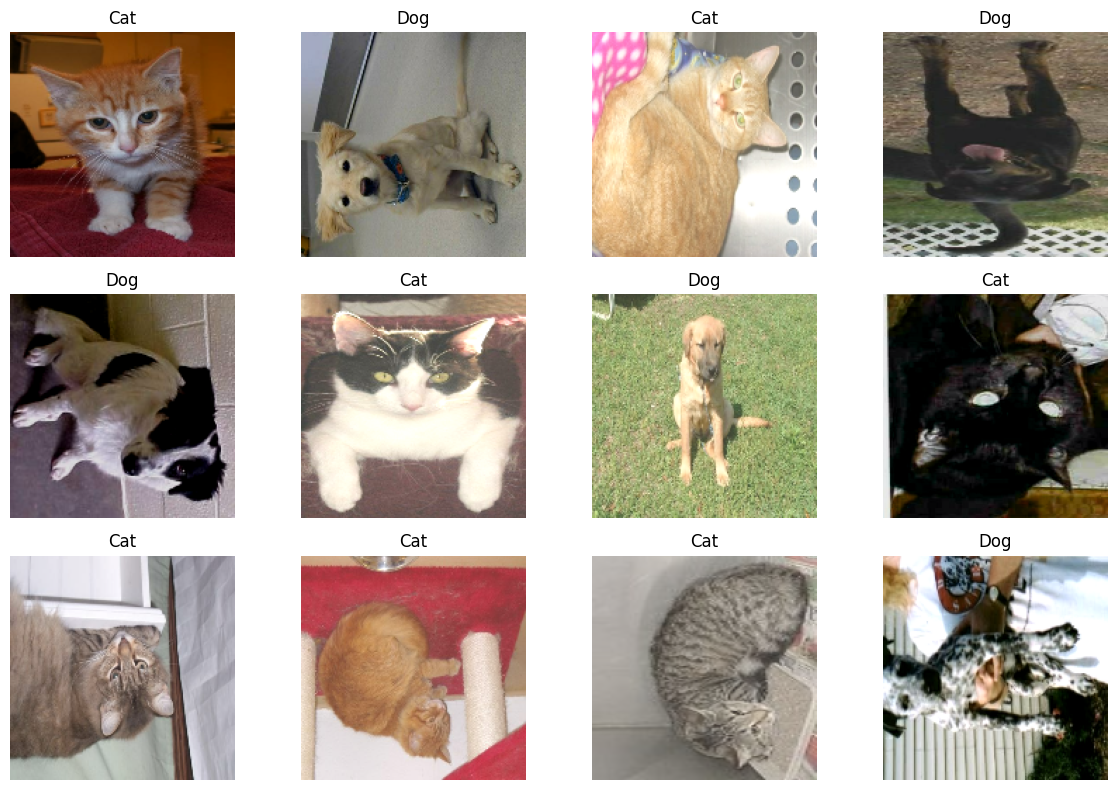

In [9]:
def show_batch(dataset, class_names=['Cat', 'Dog']):
    """Display a batch of images with labels"""
    plt.figure(figsize=(12, 8))

    for images, labels in dataset.take(1):
        for i in range(min(12, len(images))):
            plt.subplot(3, 4, i + 1)
            plt.imshow(images[i])
            plt.title(f'{class_names[labels[i]]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_batch(ds_train_processed)

## Load MobileNetV2 pre-trained on ImageNet

In [10]:
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,  # Exclude the final classification layer
    weights='imagenet'  # Use ImageNet weights
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_cats_dogs_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [14]:
history = model.fit(
    ds_train_processed,
    epochs=15,
    validation_data=ds_val_processed,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8030 - loss: 0.4147
Epoch 1: val_accuracy improved from -inf to 0.96476, saving model to best_cats_dogs_model.h5


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.8030 - loss: 0.4146 - val_accuracy: 0.9648 - val_loss: 0.1017 - learning_rate: 1.0000e-04
Epoch 2/15
1016/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9017 - loss: 0.2375
Epoch 2: val_accuracy improved from 0.96476 to 0.96676, saving model to best_cats_dogs_model.h5


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9017 - loss: 0.2375 - val_accuracy: 0.9668 - val_loss: 0.0903 - learning_rate: 1.0000e-04
Epoch 3/15
1014/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9100 - loss: 0.2129
Epoch 3: val_accuracy improved from 0.96676 to 0.97278, saving model to best_cats_dogs_model.h5


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9100 - loss: 0.2129 - val_accuracy: 0.9728 - val_loss: 0.0812 - learning_rate: 1.0000e-04
Epoch 4/15
1015/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9189 - loss: 0.1983
Epoch 4: val_accuracy improved from 0.97278 to 0.97450, saving model to best_cats_dogs_model.h5


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9189 - loss: 0.1983 - val_accuracy: 0.9745 - val_loss: 0.0792 - learning_rate: 1.0000e-04
Epoch 5/15
1015/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9241 - loss: 0.1884
Epoch 5: val_accuracy did not improve from 0.97450
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9241 - loss: 0.1885 - val_accuracy: 0.9734 - val_loss: 0.0768 - learning_rate: 1.0000e-04
Epoch 6/15
1014/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9229 - loss: 0.1831
Epoch 6: val_accuracy improved from 0.97450 to 0.97507, saving model to best_cats_dogs_model.h5


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9229 - loss: 0.1831 - val_accuracy: 0.9751 - val_loss: 0.0757 - learning_rate: 1.0000e-04
Epoch 7/15
1015/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9292 - loss: 0.1774
Epoch 7: val_accuracy did not improve from 0.97507
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9292 - loss: 0.1774 - val_accuracy: 0.9736 - val_loss: 0.0722 - learning_rate: 1.0000e-04
Epoch 8/15
1014/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9343 - loss: 0.1670
Epoch 8: val_accuracy did not improve from 0.97507
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9343 - loss: 0.1670 - val_accuracy: 0.9751 - val_loss: 0.0728 - learning_rate: 1.0000e-04
Epoch 9/15
1016/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9293 - loss: 0.1726
Epoch 9: val_accuracy did not improve from 0.97507
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9293 - loss: 0.1726 - val_accuracy: 0.9748 - val_loss: 0.0729 - learning_r

1018/1018 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9427 - loss: 0.1443 - val_accuracy: 0.9759 - val_loss: 0.0664 - learning_rate: 1.0000e-04
Epoch 14/15
1016/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9403 - loss: 0.1427
Epoch 14: val_accuracy did not improve from 0.97593
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9403 - loss: 0.1427 - val_accuracy: 0.9759 - val_loss: 0.0660 - learning_rate: 1.0000e-04
Epoch 15/15
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9459 - loss: 0.1359
Epoch 15: val_accuracy did not improve from 0.97593
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9459 - loss: 0.1359 - val_accuracy: 0.9731 - val_loss: 0.0681 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 14.


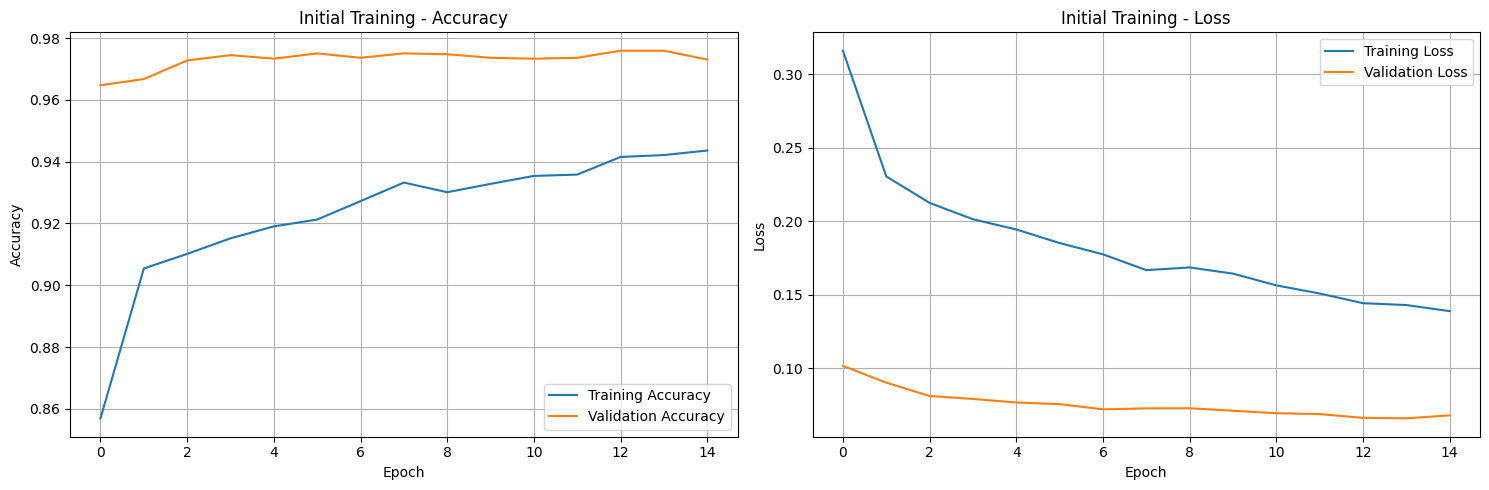

In [15]:
def plot_training_results(history, title="Training Results"):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot initial training results
plot_training_results(history, "Initial Training")

In [16]:
test_loss, test_accuracy = model.evaluate(ds_test_processed, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9695 - loss: 0.0750

Test Loss: 0.0739
Test Accuracy: 0.9708


## Fine Tuning the Model

In [17]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Trainable layers after unfreezing: {len([l for l in base_model.layers if l.trainable])}")

Trainable layers after unfreezing: 54


In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [21]:

history_fine = model.fit(
    ds_train_processed,
    epochs=25,
    initial_epoch=len(history.history['loss']),
    validation_data=ds_val_processed,
    callbacks=callbacks,
    verbose=1
)

Epoch 16/25
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8569 - loss: 0.3236
Epoch 16: val_accuracy did not improve from 0.97593
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.8569 - loss: 0.3235 - val_accuracy: 0.9725 - val_loss: 0.0692 - learning_rate: 1.0000e-05
Epoch 17/25
1016/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9182 - loss: 0.1935
Epoch 17: val_accuracy did not improve from 0.97593
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9182 - loss: 0.1935 - val_accuracy: 0.9756 - val_loss: 0.0678 - learning_rate: 1.0000e-05
Epoch 18/25
1017/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9309 - loss: 0.1649
Epoch 18: val_accuracy did not improve from 0.97593
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9309 - loss: 0.1649 - val_accuracy: 0.9736 - val_loss: 0.0660 - learning_rate: 1.0000e-05
Epoch 19/25
1016/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9408 - loss: 0.1510
Epoch 19: val_accuracy did not improv

1018/1018 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9600 - loss: 0.0981 - val_accuracy: 0.9771 - val_loss: 0.0639 - learning_rate: 1.0000e-05
Epoch 23/25
1015/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9680 - loss: 0.0849
Epoch 23: val_accuracy did not improve from 0.97708
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9680 - loss: 0.0849 - val_accuracy: 0.9751 - val_loss: 0.0667 - learning_rate: 1.0000e-05
Epoch 24/25
1015/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9715 - loss: 0.0752
Epoch 24: val_accuracy improved from 0.97708 to 0.97736, saving model to best_cats_dogs_model.h5


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9715 - loss: 0.0752 - val_accuracy: 0.9774 - val_loss: 0.0610 - learning_rate: 1.0000e-05
Epoch 25/25
1015/1018 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9742 - loss: 0.0668
Epoch 25: val_accuracy improved from 0.97736 to 0.97765, saving model to best_cats_dogs_model.h5


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9742 - loss: 0.0668 - val_accuracy: 0.9777 - val_loss: 0.0656 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 24.


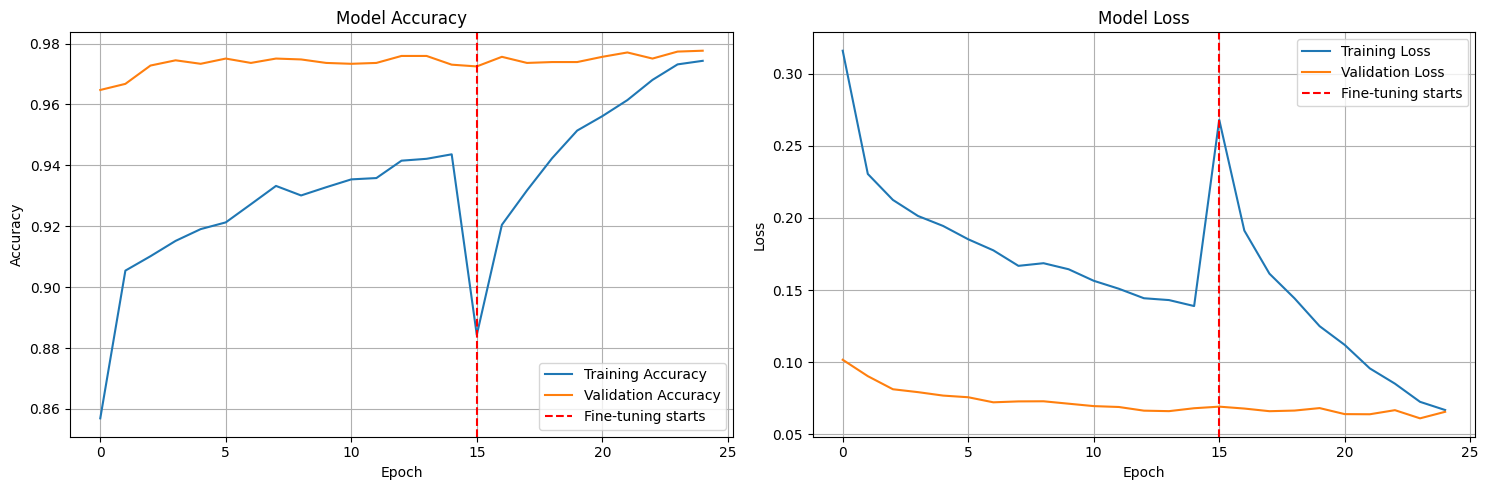

In [22]:
def plot_complete_training(history, history_fine):
    """Plot complete training history including fine-tuning"""
    # Combine histories
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--',
                label='Fine-tuning starts')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(x=len(history.history['loss']), color='r', linestyle='--',
                label='Fine-tuning starts')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot complete training results
plot_complete_training(history, history_fine)

In [23]:
test_loss, test_accuracy = model.evaluate(ds_test_processed, verbose=0)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.0803
Test Accuracy: 0.9719


## Prediction and Visualization


Sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


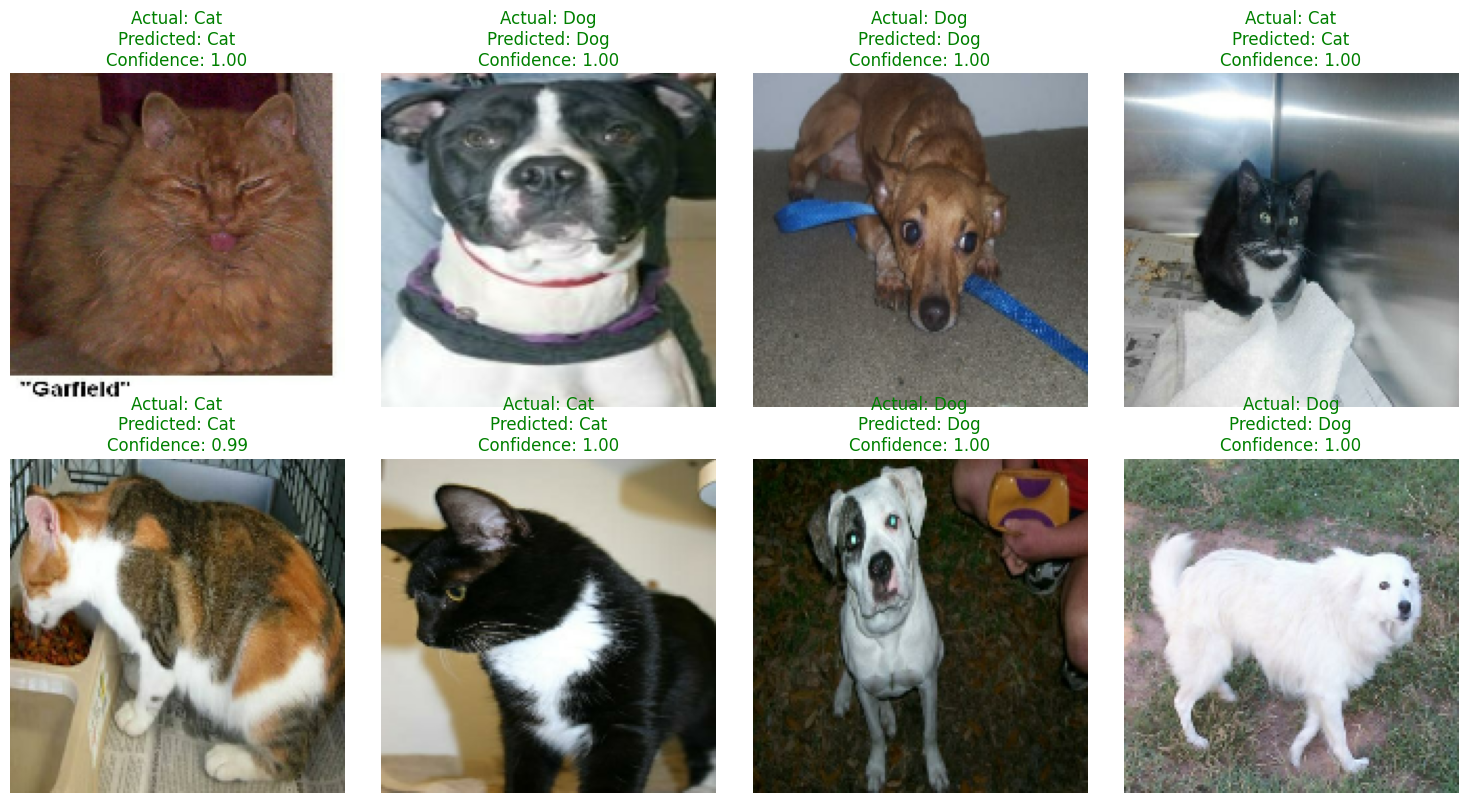

In [24]:

def predict_and_visualize(model, dataset, num_images=8):
    """Make predictions and visualize results"""
    class_names = ['Cat', 'Dog']

    plt.figure(figsize=(15, 8))

    for images, labels in dataset.take(1):
        predictions = model.predict(images)

        for i in range(min(num_images, len(images))):
            plt.subplot(2, 4, i + 1)
            plt.imshow(images[i])

            predicted_class = 1 if predictions[i] > 0.5 else 0
            actual_class = labels[i].numpy()
            confidence = predictions[i][0] if predicted_class == 1 else 1 - predictions[i][0]

            color = 'green' if predicted_class == actual_class else 'red'

            plt.title(f'Actual: {class_names[actual_class]}\n'
                     f'Predicted: {class_names[predicted_class]}\n'
                     f'Confidence: {confidence:.2f}', color=color)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions on test set
print("\nSample predictions:")
predict_and_visualize(model, ds_test_processed)

## Save the model

In [25]:
model.save('cats_vs_dogs_final_model.h5')

## Dipu Ghosh
## 221-35-873
## Section: 37_B1